In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard.writer import SummaryWriter

from sklearn.model_selection import train_test_split

from common import data
from common.training import training_loop, get_predictions

from algos import cbl_2 as cbl
from algos.supervised import SupervisedEngine

from common.models import resnet, deeplab
from common import metrics
from common.models.modutils import load_model


# Hyperparameters

In [3]:
log_dir = "./outputs/cbl_instance_norm"

horizon = 1024
stride = 512

batch_size_con = 8
batch_size_sup = 16

num_epochs_con = 10
num_epochs_sup = 5

learning_rate_con = 1e-3
learning_rate_sup = 1e-3

weight_decay_con = 1e-2
weight_decay_sup = 1e-2

supervised_percentage = 0.25

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


# Contrastive

## Datasets

In [4]:
paths = data.get_dataset_paths("../data")
train, test = train_test_split(paths, test_size=0.1, random_state=42)


In [5]:
m_data_train = data.Marconi100Dataset(train, scaling=data.Scaling.STANDARD)
m_data_test = data.Marconi100Dataset(test, scaling=data.Scaling.STANDARD)


Loading: 100%|██████████| 25/25 [00:13<00:00,  1.82it/s]


In [6]:
train_loader = DataLoader(
    data.UnfoldedDataset(m_data_train, horizon=horizon, stride=stride),
    batch_size_con,
    shuffle=True,
)
test_loader = DataLoader(
    data.UnfoldedDataset(m_data_test, horizon=horizon, stride=stride),
    batch_size_con,
    shuffle=False,
)


## Model

In [7]:
backbone = resnet.ResNetFeatures(
    resnet.Bottleneck,
    resnet.RESNET50_LAYERS,
    num_features=data.NUM_FEATURES,
    return_layers=[resnet.LAYER_1, resnet.LAYER_4],
    replace_stride_with_dilation=[False, True, True],
    norm_layer=torch.nn.InstanceNorm1d
)

contrastive_model = resnet.ResNet(backbone, 128)
optim = AdamW(contrastive_model.parameters(), lr=learning_rate_con, weight_decay=weight_decay_con)
lr_sched = CosineAnnealingLR(optim, num_epochs_con)

aug = cbl.pipeline(
    cbl.random_apply(cbl.left_to_right_flipping(1), 0.5),
    cbl.random_apply(cbl.crop_and_resize(1.5, 3), 0.8),
)

engine_contrastive = cbl.CBLFeatsEngine(
    model=contrastive_model,
    optimizer=optim,
    temperature=0.5,
    aug_1=aug,
    aug_2=aug,
    lr_scheduler=lr_sched,
    device=device,
)


## Training

In [8]:
with SummaryWriter(log_dir + "/contrastive/logs") as writer:
    training_loop(
        engine=engine_contrastive,
        num_epochs=num_epochs_con,
        train_dataloader=train_loader,
        test_dataloader=test_loader,
        writer=writer,
        save_path=log_dir + "/contrastive/models",
    )


Epoch 0 - train_loss = 2.555 - test_loss = 2.706 - lr = 1.00e-03


Epoch 1 - train_loss = 2.527 - test_loss = 2.673 - lr = 9.76e-04


Epoch 2 - train_loss = 2.338 - test_loss = 2.617 - lr = 9.05e-04


Epoch 3 - train_loss = 2.212 - test_loss = 2.593 - lr = 7.94e-04


Epoch 4 - train_loss = 2.069 - test_loss = 2.463 - lr = 6.55e-04


Epoch 5 - train_loss = 1.980 - test_loss = 2.429 - lr = 5.00e-04


Epoch 6 - train_loss = 1.869 - test_loss = 2.347 - lr = 3.45e-04


Epoch 7 - train_loss = 1.559 - test_loss = 2.372 - lr = 2.06e-04


Epoch 8 - train_loss = 1.745 - test_loss = 2.359 - lr = 9.55e-05


Epoch 9 - train_loss = 1.755 - test_loss = 2.411 - lr = 2.45e-05


# Supervised

## Dataset

In [9]:
n_samples = int(len(test) * supervised_percentage)
m_data_train.data = m_data_train.data[:n_samples]

sup_loader = DataLoader(
    data.UnfoldedDataset(m_data_train, horizon=horizon, stride=stride),
    batch_size_sup,
    shuffle=True,
)


## Model

In [10]:
for p in backbone.parameters():
    p.requires_grad = False

model = deeplab.DeepLabNet(backbone, backbone_channels=[256, 2048], out_feats=1)

optim = AdamW(
    model.head.parameters(), lr=learning_rate_sup, weight_decay=weight_decay_sup
)
lr_sched = CosineAnnealingLR(optim, num_epochs_sup)
engine_supervised = SupervisedEngine(
    model, device, optimizer=optim, lr_scheduler=lr_sched
)


## Training

In [11]:
with SummaryWriter(log_dir + "/supervised/logs") as writer:
    training_loop(
        engine=engine_supervised,
        num_epochs=num_epochs_sup,
        train_dataloader=sup_loader,
        test_dataloader=test_loader,
        writer=writer,
        save_path=log_dir + "/supervised/models",
    )


Epoch 0 - train_loss = 0.374 - test_loss = 0.659 - lr = 1.00e-03


Epoch 1 - train_loss = 0.188 - test_loss = 0.223 - lr = 9.05e-04


Epoch 2 - train_loss = 0.155 - test_loss = 0.204 - lr = 6.55e-04


Epoch 3 - train_loss = 0.133 - test_loss = 0.185 - lr = 3.45e-04


Epoch 4 - train_loss = 0.115 - test_loss = 0.188 - lr = 9.55e-05


# Evaluating

In [12]:
load_model(model, log_dir + "/supervised/models/model_4.pth", device);

In [13]:
# Cost model
cmodel = metrics.default_cmodel()


In [14]:
scores, labels = get_predictions(engine_supervised.predict, test_loader)


100%|██████████| 81/81 [00:09<00:00,  8.37it/s]


In [15]:
cmodel.fit(scores, labels).optimize()


(-1.8739959049224666, 218.89026)

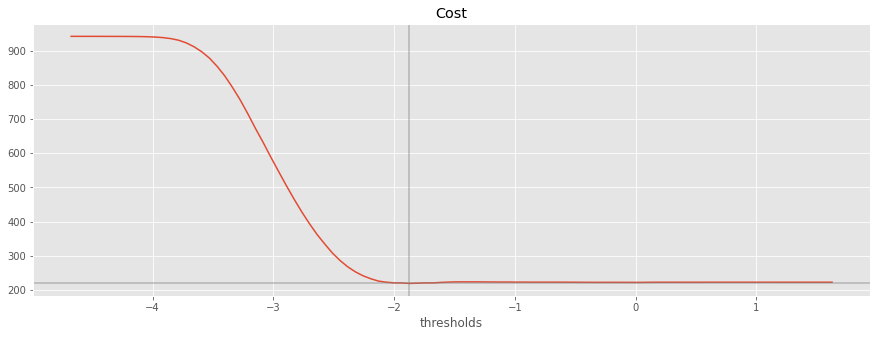

In [16]:
metrics.plot_cost(cmodel)


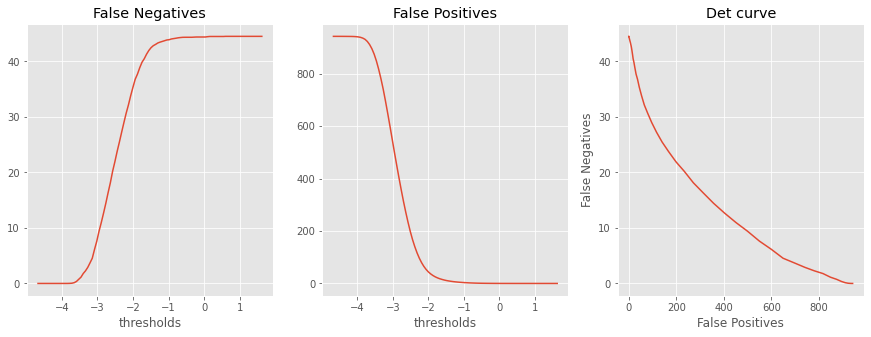

In [17]:
metrics.plot_errors_curve(
    cmodel.false_positives, cmodel.false_negatives, cmodel.thresholds, figsize=(15, 5)
)


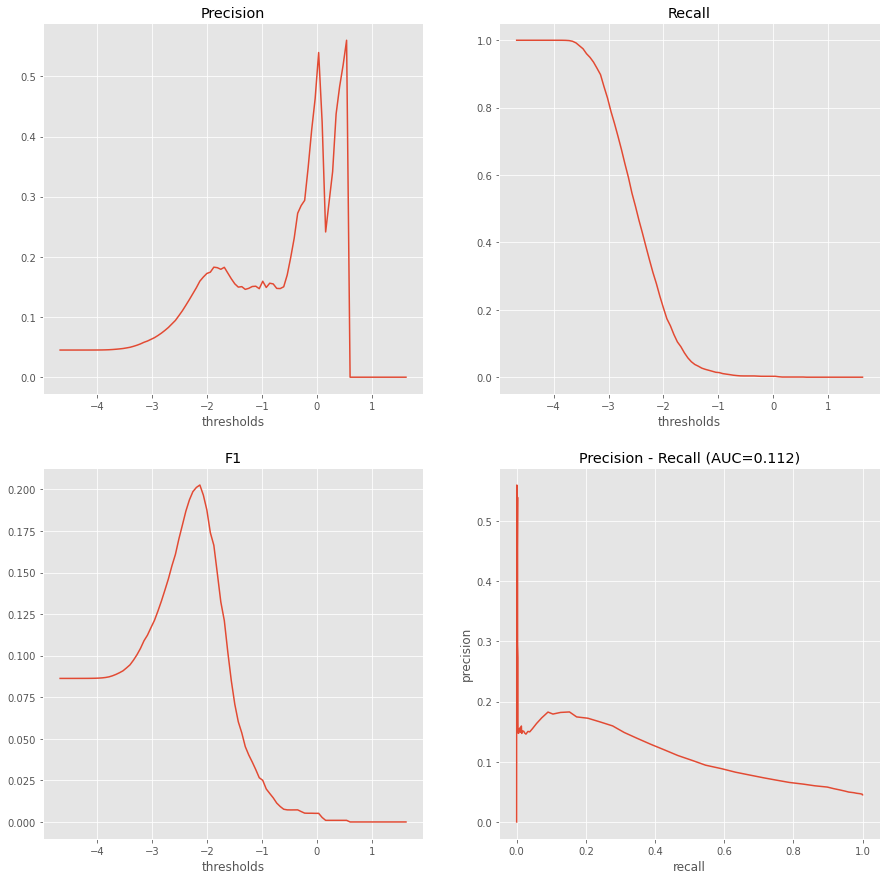

In [18]:
pr, rec, f1 = metrics.precision_recall_f1(
    cmodel.false_positives, cmodel.false_negatives
)
metrics.plot_precision_recall_f1_curve(pr, rec, f1, cmodel.thresholds)


In [20]:
with torch.no_grad():
    engine_contrastive.model.train()
    tl = 0
    for b in tqdm(sup_loader):
        tl += engine_contrastive._get_loss(b)
    tl /= len(sup_loader)
    sl = 0
    for b in tqdm(test_loader):
        sl += engine_contrastive._get_loss(b)
    sl /= len(test_loader)

    print("TRAIN loss TRAIN mode", tl.item())
    print("TEST loss TRAIN mode", sl.item())
    engine_contrastive.model.eval()
    tl = 0
    for b in tqdm(sup_loader):
        tl += engine_contrastive._get_loss(b)
    tl /= len(sup_loader)
    sl = 0
    for b in tqdm(test_loader):
        sl += engine_contrastive._get_loss(b)
    sl /= len(test_loader)

    print("TRAIN loss EVAL mode", tl.item())
    print("TEST loss EVAL mode", sl.item())

100%|██████████| 81/81 [00:12<00:00,  6.52it/s]


TRAIN loss TRAIN mode 2.454958438873291
TEST loss TRAIN mode 2.3812899589538574


100%|██████████| 81/81 [00:12<00:00,  6.56it/s]

TRAIN loss EVAL mode 2.4433400630950928
TEST loss EVAL mode 2.320758819580078
